In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
# from DYNASMART_Process import *
from Modules import DYNASMART_Process as dy
# import preprocessing_read_skim_file as rs
from Modules import AV_functions as av
from Modules import Solve_DARP as sod
from Modules import Postprocess_DARP as pod
from Modules import Preprocess_DARP as prd
from Modules import DARP_to_DYNA as dtd
from gurobipy import *
from Modules import *
import datetime
import requests
import math
import importlib
import random
from Modules import SOD_SA
%load_ext autoreload
%autoreload 2

In [2]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
personData=pd.read_csv('input/personData_1.csv')
person_type_dic=dict(zip(personData.person_id,personData.type))
traveler_trips=pd.read_csv('input/traveler_trip_info_improved.csv',index_col=0)
num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
superzone_filepath='Input/SuperZone.dat'
linktraveltime_filepath='Input/output_td_linktraveltime.dat'
superzone_map=dy.read_superzone_info(superzone_filepath)
origin_path='Input/origin.dat'
destination_path='Input/destination.dat'
origins,destinations,origin_links=dy.read_origin_destion(origin_path,destination_path)
origin_links['length']=origin_links.apply(lambda row: 
                                          link_detail[int(link_id[node_id[row.u_node],node_id[row.d_node]])][0,4],axis=1)
VPNRSkim_folder_filepath='Input/vehicularPNRSkim'
Vehicular_Skim,Vehicular_Skim_Dict=dy.read_vehicle_skim(VPNRSkim_folder_filepath)
transit_skim_folderpath='Input/'
TransitMazTazFlag,drivingweight,walkingweight,\
TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,\
Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk=dy.read_transitskim(transit_skim_folderpath)
Transit_AB_Cost_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Cost_Skim,TransitSkimTimeIntervalLength)
Transit_AB_Time_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Time_Skim,TransitSkimTimeIntervalLength)
transit_zone_dict={}
for link_zone in three_link_walk.three_link_zone.unique():
    transit_zone_dict[link_zone]=list(three_link_walk[three_link_walk.three_link_zone==link_zone]['transit_zone'].astype(int))
three_link_walk_dict={}
for index,group in three_link_walk.groupby(['three_link_zone']):
    three_link_walk_dict[index]={}
    for inx,row in group.iterrows():
        three_link_walk_dict[index][row.transit_zone]=row.distance
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
drivingcost_per_mile=0.5
intrasuperzone_info,intrasuperzone_path_dic=dtd.read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)
traveler_trips=prd.compare_mode_utlity(traveler_trips,TransitMazTazFlag,
                        three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
                        Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
                        Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)

56 57 72


In [3]:
car_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>=1)]
car_trips=car_trips.loc[(car_trips.orig_taz !=car_trips.dest_taz) | (car_trips.trip_counter==1)]
car_transit_trips=car_trips.append(traveler_trips[traveler_trips.tripmode>8])
# car_transit_trips=prd.compare_mode_utlity(car_transit_trips,TransitMazTazFlag,
#                         three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
#                         Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
#                         Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)
random.seed(100)
car_transit_trips_sample=car_transit_trips[car_transit_trips.hh_id.isin(random.sample(list(car_transit_trips.hh_id.unique()),3000))]
car_trips_sample=car_trips[car_trips.hh_id.isin(random.sample(list(car_transit_trips.hh_id.unique()),3000))]

In [ ]:
deviation_list=[]
num_trips=[]
hh_id_list=[]
target_darp_solutions=darp_solutions_modechoice05vot
for hh_id in car_transit_trips.hh_id.unique():
    hh_id_list.extend([hh_id])
    num_trips.extend([target_darp_solutions[hh_id]['num_pickup_trips']])
    deviation_list.extend([target_darp_solutions[hh_id]['schedule_deviation']])
deviation=pd.DataFrame({'hh_id':hh_id_list,'num_trips':num_trips,'deviation_list':deviation_list})
deviation.deviation_list.sum()/deviation.num_trips.sum()

In [77]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=0
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
if num_time_interval==5:
    TL=[0,280,420,780,960]
    TU=[280,420,780,960,1440]
else:
    TL=[i*1440/num_time_interval for i in range(num_time_interval)]
    TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0

print('********************************')
print(share_ride_factor)
# target_trips=car_trips_sample[car_trips_sample.hh_id==1486727]

route_info_ca15_sample,darp_solutions_ca15_sample=\
sod.get_route_info_allhh(car_trips_sample,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )

********************************
1.5
Estimate Route for the  0 th household  2018-08-12 09:37:13.226176
Estimate Route for the  1000 th household  2018-08-12 09:46:57.680371
Estimate Route for the  2000 th household  2018-08-12 09:52:52.243522


In [335]:
car_trips_sample[car_trips_sample.hh_id==298246][['orig_purpose','dest_purpose','starttime','person_id']].sort_values(by='starttime')

,orig_purpose,dest_purpose,starttime,person_id
72845,Home,WorkBased,206.0,703919
72846,WorkBased,Work,225.0,703919
259093,Home,Discretionary,332.0,703920
259094,Discretionary,Shop,586.0,703920
259095,Shop,Home,630.0,703920
259096,Home,Work,784.0,703920
72847,Work,Maintenance,793.0,703919
259098,Shop,Home,870.0,703920
72848,Maintenance,Home,897.0,703919


In [161]:
output_flag=0
single_model_runtime=60*2
num_time_interval=5
if num_time_interval==5:
    TL=[0,280,420,780,960]
    TU=[280,420,780,960,1440]
else:
    TL=[i*1440/num_time_interval for i in range(num_time_interval)]
    TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
route_info_sa_sample,darp_solutions_sa_sample=SOD_SA.get_route_info_allhh_sa(car_trips_sample,darp_solutions_ca15_sample,
        output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
        reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor,time_window_flag,
        Vehicular_Skim_Dict,Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,superzone_map,TL,TU,transit_zone_dict,transit_zone_candidates,
        TransitMazTazFlag,TransitSkimTimeIntervalLength)

Estimate Route for the  0 th household  2018-08-12 14:46:52.160855
2018-08-12 14:46:52.387868 	 928 	 14 	 1588492
2018-08-12 14:48:54.753825 	 929 	 9 	 1588508
2018-08-12 14:48:59.229079 	 930 	 9 	 1588516
2018-08-12 14:49:02.088242 	 931 	 10 	 1588543
2018-08-12 14:49:03.681332 	 932 	 4 	 1588544
2018-08-12 14:49:04.136369 	 933 	 9 	 1588546
2018-08-12 14:49:07.056524 	 934 	 8 	 1588570
2018-08-12 14:49:07.977577 	 935 	 9 	 1588586
2018-08-12 14:49:09.874685 	 936 	 2 	 1588588
2018-08-12 14:49:10.013692 	 937 	 7 	 1588589
2018-08-12 14:49:10.906742 	 938 	 11 	 1588593
2018-08-12 14:49:14.421945 	 939 	 11 	 1588599
2018-08-12 14:49:17.673128 	 940 	 6 	 1589491
2018-08-12 14:49:18.437172 	 941 	 20 	 1589498
2018-08-12 14:51:23.507281 	 942 	 6 	 1589544
2018-08-12 14:51:25.564400 	 943 	 4 	 1589548
2018-08-12 14:51:25.908424 	 944 	 4 	 1589552
2018-08-12 14:51:26.258438 	 945 	 10 	 1589554
2018-08-12 14:51:31.475738 	 946 	 11 	 1589767
2018-08-12 14:51:44.829493 	 947 

2018-08-12 15:25:14.040956 	 1097 	 4 	 1839534
2018-08-12 15:25:14.950021 	 1098 	 5 	 1839536
2018-08-12 15:25:15.423059 	 1099 	 8 	 1839547
2018-08-12 15:25:26.034797 	 1100 	 7 	 1839550
2018-08-12 15:25:26.903856 	 1101 	 5 	 1839568
2018-08-12 15:25:27.745920 	 1102 	 8 	 1839591
2018-08-12 15:25:29.134012 	 1103 	 4 	 1839620
2018-08-12 15:25:29.520046 	 1104 	 6 	 1839621
2018-08-12 15:25:30.417102 	 1105 	 3 	 1839624
2018-08-12 15:25:30.653119 	 1106 	 3 	 1839638
2018-08-12 15:25:30.918137 	 1107 	 4 	 1839651
2018-08-12 15:25:31.279162 	 1108 	 7 	 1839661
2018-08-12 15:25:32.619256 	 1109 	 7 	 1839663
2018-08-12 15:25:34.918417 	 1110 	 4 	 1839666
2018-08-12 15:25:35.247440 	 1111 	 2 	 1839680
2018-08-12 15:25:35.402450 	 1112 	 19 	 1839685
2018-08-12 15:27:19.854740 	 1113 	 6 	 1839722
2018-08-12 15:27:21.132828 	 1114 	 7 	 1839744
2018-08-12 15:27:22.692921 	 1115 	 5 	 1839752
2018-08-12 15:27:23.176951 	 1116 	 10 	 1839899
2018-08-12 15:29:24.756660 	 1117 	 6 

2018-08-12 15:42:01.953488 	 1268 	 4 	 1845767
2018-08-12 15:42:02.315504 	 1269 	 7 	 1944622
2018-08-12 15:42:04.185601 	 1270 	 3 	 1944628
2018-08-12 15:42:04.427608 	 1271 	 4 	 1944639
2018-08-12 15:42:04.792627 	 1272 	 5 	 1944648
2018-08-12 15:42:05.672671 	 1273 	 2 	 1944701
2018-08-12 15:42:05.836679 	 1274 	 6 	 1945091
2018-08-12 15:42:06.704723 	 1275 	 8 	 1945102
2018-08-12 15:42:07.770777 	 1276 	 11 	 1945153
2018-08-12 15:43:03.148585 	 1277 	 3 	 1945175
2018-08-12 15:43:03.372596 	 1278 	 3 	 1945178
2018-08-12 15:43:03.952625 	 1279 	 6 	 1945179
2018-08-12 15:43:06.378749 	 1280 	 9 	 1945247
2018-08-12 15:43:07.592810 	 1281 	 5 	 1945255
2018-08-12 15:43:08.085836 	 1282 	 2 	 1945276
2018-08-12 15:43:08.238843 	 1283 	 3 	 1945284
2018-08-12 15:43:08.531858 	 1284 	 12 	 1945289
2018-08-12 15:43:12.678068 	 1285 	 6 	 1972418
2018-08-12 15:43:13.750122 	 1286 	 4 	 1972427
2018-08-12 15:43:14.121144 	 1287 	 13 	 1972432
2018-08-12 15:45:16.221755 	 1288 	 2

2018-08-12 16:21:00.892606 	 1438 	 13 	 2101367
2018-08-12 16:23:03.117556 	 1439 	 7 	 2101380
2018-08-12 16:23:03.954602 	 1440 	 2 	 2101384
2018-08-12 16:23:04.116612 	 1441 	 2 	 2101391
2018-08-12 16:23:04.339624 	 1442 	 10 	 2101406
2018-08-12 16:23:09.702934 	 1443 	 2 	 2101407
2018-08-12 16:23:09.853938 	 1444 	 18 	 2101410
2018-08-12 16:25:14.626032 	 1445 	 19 	 2101411
2018-08-12 16:27:19.184115 	 1446 	 6 	 2101471
2018-08-12 16:27:20.553196 	 1447 	 13 	 2101474
2018-08-12 16:29:22.939249 	 1448 	 17 	 2101477
2018-08-12 16:30:50.343796 	 1449 	 14 	 2101486
2018-08-12 16:30:59.627385 	 1450 	 2 	 2101494
2018-08-12 16:30:59.776392 	 1451 	 15 	 2101498
2018-08-12 16:31:08.914966 	 1452 	 11 	 2101508
2018-08-12 16:31:11.394129 	 1453 	 3 	 2101518
2018-08-12 16:31:11.650139 	 1454 	 6 	 2101519
2018-08-12 16:31:12.664204 	 1455 	 4 	 2101533
2018-08-12 16:31:13.019227 	 1456 	 4 	 2101535
2018-08-12 16:31:13.367249 	 1457 	 9 	 2101546
2018-08-12 16:31:17.102491 	 14

2018-08-12 17:00:31.437079 	 1608 	 13 	 2176986
2018-08-12 17:02:33.574019 	 1609 	 7 	 2176988
2018-08-12 17:02:42.383520 	 1610 	 9 	 2177074
2018-08-12 17:02:46.884774 	 1611 	 5 	 2177082
2018-08-12 17:02:48.163853 	 1612 	 7 	 2177091
2018-08-12 17:02:48.946893 	 1613 	 3 	 2177211
2018-08-12 17:02:49.191908 	 1614 	 16 	 2177223
2018-08-12 17:03:59.820922 	 1615 	 13 	 2177234
2018-08-12 17:05:13.605121 	 1616 	 7 	 2177248
2018-08-12 17:05:14.332163 	 1617 	 10 	 2177257
2018-08-12 17:05:17.154319 	 1618 	 2 	 2177267
2018-08-12 17:05:17.309332 	 1619 	 9 	 2177273
2018-08-12 17:05:43.315805 	 1620 	 9 	 2177281
2018-08-12 17:05:46.164974 	 1621 	 11 	 2177285
2018-08-12 17:06:23.117068 	 1622 	 8 	 2177287
2018-08-12 17:06:24.552151 	 1623 	 11 	 2208985
2018-08-12 17:06:36.503829 	 1624 	 7 	 2211900
2018-08-12 17:06:39.450002 	 1625 	 13 	 2211919
2018-08-12 17:06:45.497345 	 1626 	 20 	 2211934
2018-08-12 17:08:50.581021 	 1627 	 9 	 2211959
2018-08-12 17:09:15.110575 	 162

2018-08-12 17:51:01.004534 	 1778 	 2 	 2566045
2018-08-12 17:51:01.197544 	 1779 	 3 	 2566056
2018-08-12 17:51:01.454559 	 1780 	 3 	 2566059
2018-08-12 17:51:01.742578 	 1781 	 3 	 2566076
2018-08-12 17:51:02.027592 	 1782 	 7 	 2566094
2018-08-12 17:51:02.912643 	 1783 	 2 	 2566108
2018-08-12 17:51:03.074651 	 1784 	 3 	 2566117
2018-08-12 17:51:03.381669 	 1785 	 6 	 2566123
2018-08-12 17:51:04.789751 	 1786 	 2 	 2566126
2018-08-12 17:51:04.948757 	 1787 	 5 	 2566132
2018-08-12 17:51:06.855871 	 1788 	 5 	 2566142
2018-08-12 17:51:07.377897 	 1789 	 2 	 2566163
2018-08-12 17:51:07.587907 	 1790 	 2 	 2566182
2018-08-12 17:51:07.766923 	 1791 	 5 	 2566189
2018-08-12 17:51:08.252951 	 1792 	 2 	 2566195
2018-08-12 17:51:08.426955 	 1793 	 6 	 2566198
2018-08-12 17:51:10.432073 	 1794 	 2 	 2566200
2018-08-12 17:51:10.591084 	 1795 	 4 	 2566230
2018-08-12 17:51:11.122108 	 1796 	 4 	 2566244
2018-08-12 17:51:11.522132 	 1797 	 6 	 2566260
2018-08-12 17:51:12.257173 	 1798 	 2 	 

2018-08-12 17:55:02.355257 	 1949 	 2 	 2824912
2018-08-12 17:55:02.543271 	 1950 	 2 	 2824916
2018-08-12 17:55:02.709275 	 1951 	 4 	 2824926
2018-08-12 17:55:03.083302 	 1952 	 4 	 2824929
2018-08-12 17:55:03.456318 	 1953 	 2 	 2824931
2018-08-12 17:55:03.623327 	 1954 	 6 	 2824940
2018-08-12 17:55:04.468375 	 1955 	 5 	 2824945
2018-08-12 17:55:05.004405 	 1956 	 6 	 2824949
2018-08-12 17:55:07.194529 	 1957 	 2 	 2824955
2018-08-12 17:55:07.373540 	 1958 	 1 	 2824967
2018-08-12 17:55:07.501546 	 1959 	 2 	 2824975
2018-08-12 17:55:07.662561 	 1960 	 7 	 2824976
2018-08-12 17:55:08.557607 	 1961 	 3 	 2824987
2018-08-12 17:55:09.325651 	 1962 	 4 	 2825006
2018-08-12 17:55:09.716673 	 1963 	 2 	 2825018
2018-08-12 17:55:09.881682 	 1964 	 1 	 2825035
2018-08-12 17:55:10.011690 	 1965 	 6 	 2825058
2018-08-12 17:55:10.715736 	 1966 	 4 	 2825061
2018-08-12 17:55:11.105752 	 1967 	 2 	 2825067
2018-08-12 17:55:11.315763 	 1968 	 5 	 2825080
2018-08-12 17:55:11.957800 	 1969 	 2 	 

2018-08-12 18:00:47.640039 	 2118 	 4 	 2980158
2018-08-12 18:00:48.069067 	 2119 	 2 	 2980168
2018-08-12 18:00:48.228076 	 2120 	 1 	 2980173
2018-08-12 18:00:48.330082 	 2121 	 4 	 2980180
2018-08-12 18:00:48.671101 	 2122 	 2 	 2980189
2018-08-12 18:00:48.829109 	 2123 	 3 	 2980192
2018-08-12 18:00:49.076120 	 2124 	 2 	 2980197
2018-08-12 18:00:49.243127 	 2125 	 3 	 2980199
2018-08-12 18:00:49.482143 	 2126 	 7 	 2980203
2018-08-12 18:00:52.840338 	 2127 	 2 	 2980205
2018-08-12 18:00:53.277357 	 2128 	 1 	 2980225
2018-08-12 18:00:53.386363 	 2129 	 5 	 2980230
2018-08-12 18:00:54.103404 	 2130 	 2 	 2980248
2018-08-12 18:00:54.269413 	 2131 	 4 	 2980249
2018-08-12 18:00:54.683437 	 2132 	 4 	 2980274
2018-08-12 18:00:55.228469 	 2133 	 2 	 2980306
2018-08-12 18:00:55.454481 	 2134 	 8 	 2980333
2018-08-12 18:00:59.712728 	 2135 	 5 	 2980341
2018-08-12 18:01:00.304756 	 2136 	 2 	 2980349
2018-08-12 18:01:00.464766 	 2137 	 5 	 2980351
2018-08-12 18:01:01.018796 	 2138 	 2 	 

2018-08-12 18:06:32.431638 	 2289 	 4 	 3092694
2018-08-12 18:06:32.766657 	 2290 	 2 	 3092696
2018-08-12 18:06:32.925666 	 2291 	 14 	 3092703
2018-08-12 18:08:35.702646 	 2292 	 2 	 3092750
2018-08-12 18:08:35.872656 	 2293 	 4 	 3092763
2018-08-12 18:08:36.298680 	 2294 	 6 	 3092799
2018-08-12 18:08:37.479747 	 2295 	 4 	 3092825
2018-08-12 18:08:37.885770 	 2296 	 2 	 3092832
2018-08-12 18:08:38.065781 	 2297 	 2 	 3092840
2018-08-12 18:08:38.242790 	 2298 	 6 	 3092842
2018-08-12 18:08:39.811885 	 2299 	 8 	 3118647
2018-08-12 18:08:41.103953 	 2300 	 4 	 3118652
2018-08-12 18:08:41.464974 	 2301 	 4 	 3118654
2018-08-12 18:08:42.338023 	 2302 	 4 	 3118689
2018-08-12 18:08:42.673044 	 2303 	 11 	 3118717
2018-08-12 18:08:44.873168 	 2304 	 11 	 3118731
2018-08-12 18:08:49.329421 	 2305 	 14 	 3118759
2018-08-12 18:10:51.816465 	 2306 	 7 	 3118761
2018-08-12 18:10:56.235744 	 2307 	 3 	 3118764
2018-08-12 18:10:56.474765 	 2308 	 9 	 3118772
2018-08-12 18:10:58.896913 	 2309 	 

2018-08-12 18:27:02.130510 	 2460 	 9 	 3282158
2018-08-12 18:27:05.533704 	 2461 	 15 	 3282179
2018-08-12 18:29:08.855715 	 2462 	 6 	 3282183
2018-08-12 18:29:09.654760 	 2463 	 4 	 3282198
2018-08-12 18:29:10.153789 	 2464 	 6 	 3282201
2018-08-12 18:29:10.891831 	 2465 	 5 	 3282213
2018-08-12 18:29:11.481864 	 2466 	 8 	 3282215
2018-08-12 18:29:14.767051 	 2467 	 3 	 3282223
2018-08-12 18:29:15.165073 	 2468 	 4 	 3282233
2018-08-12 18:29:15.528094 	 2469 	 2 	 3282239
2018-08-12 18:29:15.682103 	 2470 	 8 	 3282337
2018-08-12 18:29:17.538209 	 2471 	 6 	 3282343
2018-08-12 18:29:18.389257 	 2472 	 7 	 3282354
2018-08-12 18:29:19.712332 	 2473 	 8 	 3282367
2018-08-12 18:29:20.896400 	 2474 	 6 	 3282368
2018-08-12 18:29:24.184592 	 2475 	 7 	 3282376
2018-08-12 18:29:25.177643 	 2476 	 8 	 3282379
2018-08-12 18:29:35.062207 	 2477 	 6 	 3282385
2018-08-12 18:29:36.000264 	 2478 	 10 	 3282396
2018-08-12 18:29:47.191897 	 2479 	 2 	 3307888
2018-08-12 18:29:47.344903 	 2480 	 19

2018-08-12 18:53:02.463143 	 2631 	 4 	 3440457
2018-08-12 18:53:02.791162 	 2632 	 7 	 3440510
2018-08-12 18:53:03.977229 	 2633 	 6 	 3440538
2018-08-12 18:53:04.641268 	 2634 	 16 	 3440685
2018-08-12 18:53:17.621006 	 2635 	 3 	 3440695
2018-08-12 18:53:17.852018 	 2636 	 12 	 3440726
2018-08-12 18:54:03.450616 	 2637 	 6 	 3440727
2018-08-12 18:54:04.949695 	 2638 	 12 	 3440775
2018-08-12 18:54:54.731526 	 2639 	 10 	 3440777
2018-08-12 18:54:56.558635 	 2640 	 10 	 3440783
2018-08-12 18:55:06.749209 	 2641 	 8 	 3440788
2018-08-12 18:55:10.310412 	 2642 	 3 	 3440789
2018-08-12 18:55:10.551425 	 2643 	 5 	 3440794
2018-08-12 18:55:11.547482 	 2644 	 6 	 3440844
2018-08-12 18:55:12.124520 	 2645 	 2 	 3440848
2018-08-12 18:55:12.281524 	 2646 	 4 	 3440864
2018-08-12 18:55:12.632544 	 2647 	 5 	 3450240
2018-08-12 18:55:13.125572 	 2648 	 6 	 3450244
2018-08-12 18:55:14.427646 	 2649 	 4 	 3450291
2018-08-12 18:55:14.758664 	 2650 	 6 	 3450428
2018-08-12 18:55:15.433704 	 2651 	

2018-08-12 19:12:10.372862 	 2803 	 2 	 3578881
2018-08-12 19:12:10.540871 	 2804 	 6 	 3578917
2018-08-12 19:12:11.669941 	 2805 	 5 	 3578945
2018-08-12 19:12:12.141962 	 2806 	 2 	 3578948
2018-08-12 19:12:12.302971 	 2807 	 2 	 3579009
2018-08-12 19:12:12.519984 	 2808 	 2 	 3579049
2018-08-12 19:12:12.682993 	 2809 	 3 	 3579085
2018-08-12 19:12:12.938008 	 2810 	 6 	 3579095
2018-08-12 19:12:13.639047 	 2811 	 2 	 3579106
2018-08-12 19:12:13.802057 	 2812 	 3 	 3579108
2018-08-12 19:12:14.032070 	 2813 	 4 	 3579126
2018-08-12 19:12:14.371089 	 2814 	 3 	 3579138
2018-08-12 19:12:14.617103 	 2815 	 3 	 3579157
2018-08-12 19:12:14.837115 	 2816 	 2 	 3579742
2018-08-12 19:12:14.991124 	 2817 	 4 	 3579774
2018-08-12 19:12:15.346145 	 2818 	 2 	 3579813
2018-08-12 19:12:15.507154 	 2819 	 2 	 3579858
2018-08-12 19:12:15.668162 	 2820 	 2 	 3579869
2018-08-12 19:12:15.823171 	 2821 	 2 	 3579897
2018-08-12 19:12:15.985181 	 2822 	 2 	 3579937
2018-08-12 19:12:16.147190 	 2823 	 4 	 

In [199]:
darp_solutions_ca15new=pod.load_obj('darp_solutions','Output/AllHH/CA15 new/')

In [ ]:
output_flag=0
single_model_runtime=60*2
num_time_interval=5
if num_time_interval==5:
    TL=[0,280,420,780,960]
    TU=[280,420,780,960,1440]
else:
    TL=[i*1440/num_time_interval for i in range(num_time_interval)]
    TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
target_hh_ids=car_trips.hh_id.unique()[6001:12000]
route_info_sa,darp_solutions_sa=SOD_SA.get_route_info_allhh_sa(car_trips[car_trips.hh_id.isin(target_hh_ids)],darp_solutions_ca15new,
        output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
        reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor,time_window_flag,
        Vehicular_Skim_Dict,Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,superzone_map,TL,TU,transit_zone_dict,transit_zone_candidates,
        TransitMazTazFlag,TransitSkimTimeIntervalLength)

Estimate Route for the  0 th household  2018-08-13 07:21:50.239400
2018-08-13 07:21:50.472413 	 928 	 4 	 1042205
2018-08-13 07:21:50.856435 	 929 	 3 	 1042207
2018-08-13 07:21:51.151452 	 930 	 3 	 1042212
2018-08-13 07:21:51.446472 	 931 	 4 	 1042224
2018-08-13 07:21:51.899494 	 932 	 6 	 1042225
2018-08-13 07:21:52.676544 	 933 	 6 	 1042227
2018-08-13 07:21:55.164685 	 934 	 3 	 1042228
2018-08-13 07:21:55.396694 	 935 	 10 	 1042233
2018-08-13 07:21:59.209909 	 936 	 4 	 1042234
2018-08-13 07:21:59.548928 	 937 	 3 	 1042240
2018-08-13 07:21:59.808944 	 938 	 6 	 1042244
2018-08-13 07:22:02.101073 	 939 	 6 	 1042246
2018-08-13 07:22:02.774117 	 940 	 6 	 1042249
2018-08-13 07:22:03.477152 	 941 	 2 	 1042251
2018-08-13 07:22:03.637168 	 942 	 2 	 1042255
2018-08-13 07:22:03.791171 	 943 	 6 	 1042261
2018-08-13 07:22:04.550218 	 944 	 5 	 1042264
2018-08-13 07:22:05.003244 	 945 	 1 	 1042270
2018-08-13 07:22:05.099250 	 946 	 12 	 1042277
2018-08-13 07:22:07.854406 	 947 	 4 	

2018-08-13 07:32:33.999961 	 1098 	 7 	 1113685
2018-08-13 07:32:35.132025 	 1099 	 10 	 1113687
2018-08-13 07:32:36.717116 	 1100 	 7 	 1113688
2018-08-13 07:32:37.486161 	 1101 	 8 	 1113692
2018-08-13 07:32:44.158539 	 1102 	 4 	 1113694
2018-08-13 07:32:44.520559 	 1103 	 10 	 1113699
2018-08-13 07:32:46.982699 	 1104 	 1 	 1113702
2018-08-13 07:32:47.081705 	 1105 	 10 	 1113704
2018-08-13 07:34:01.333926 	 1106 	 7 	 1113705
2018-08-13 07:34:02.476991 	 1107 	 2 	 1113709
2018-08-13 07:34:02.631999 	 1108 	 7 	 1113710
2018-08-13 07:34:03.463047 	 1109 	 16 	 1113711
2018-08-13 07:36:07.041073 	 1110 	 2 	 1113712
2018-08-13 07:36:07.200083 	 1111 	 4 	 1113713
2018-08-13 07:36:07.585104 	 1112 	 5 	 1113717
2018-08-13 07:36:08.034129 	 1113 	 3 	 1113728
2018-08-13 07:36:08.271143 	 1114 	 5 	 1113731
2018-08-13 07:36:08.753171 	 1115 	 3 	 1113732
2018-08-13 07:36:08.965182 	 1116 	 11 	 1113737
2018-08-13 07:38:10.748114 	 1117 	 8 	 1113740
2018-08-13 07:38:12.667215 	 1118 	

2018-08-13 07:51:14.423621 	 1269 	 6 	 1114494
2018-08-13 07:51:15.141662 	 1270 	 2 	 1114506
2018-08-13 07:51:15.323673 	 1271 	 2 	 1114516
2018-08-13 07:51:15.495686 	 1272 	 4 	 1114517
2018-08-13 07:51:15.984713 	 1273 	 10 	 1114518
2018-08-13 07:51:18.165834 	 1274 	 6 	 1114519
2018-08-13 07:51:18.837873 	 1275 	 19 	 1114525
2018-08-13 07:51:36.267864 	 1276 	 10 	 1114526
2018-08-13 07:51:40.087080 	 1277 	 4 	 1114527
2018-08-13 07:51:40.398098 	 1278 	 5 	 1114532
2018-08-13 07:51:40.834122 	 1279 	 7 	 1114534
2018-08-13 07:51:41.857183 	 1280 	 5 	 1114535
2018-08-13 07:51:42.341209 	 1281 	 8 	 1114537
2018-08-13 07:51:43.307264 	 1282 	 4 	 1114538
2018-08-13 07:51:43.620282 	 1283 	 6 	 1114542
2018-08-13 07:51:44.209315 	 1284 	 6 	 1114545
2018-08-13 07:51:44.790348 	 1285 	 5 	 1114546
2018-08-13 07:51:45.235373 	 1286 	 9 	 1114547
2018-08-13 07:51:46.418440 	 1287 	 7 	 1118895
2018-08-13 07:51:47.159482 	 1288 	 4 	 1118897
2018-08-13 07:51:47.684513 	 1289 	 1

2018-08-13 07:59:59.550476 	 1440 	 15 	 1120505
2018-08-13 08:00:03.097676 	 1441 	 6 	 1120509
2018-08-13 08:00:04.271750 	 1442 	 5 	 1120510
2018-08-13 08:00:04.699775 	 1443 	 11 	 1120512
2018-08-13 08:00:08.071966 	 1444 	 11 	 1120520
2018-08-13 08:00:10.286085 	 1445 	 4 	 1120524
2018-08-13 08:00:10.625104 	 1446 	 4 	 1120526
2018-08-13 08:00:10.944123 	 1447 	 6 	 1120528
2018-08-13 08:00:11.541157 	 1448 	 6 	 1120529
2018-08-13 08:00:12.184193 	 1449 	 4 	 1120532
2018-08-13 08:00:12.518212 	 1450 	 6 	 1120538
2018-08-13 08:00:13.202251 	 1451 	 6 	 1120539
2018-08-13 08:00:13.848288 	 1452 	 6 	 1120541
2018-08-13 08:00:14.553332 	 1453 	 5 	 1120549
2018-08-13 08:00:15.055359 	 1454 	 9 	 1120552
2018-08-13 08:00:17.633505 	 1455 	 4 	 1120565
2018-08-13 08:00:17.992524 	 1456 	 6 	 1120566
2018-08-13 08:00:18.809572 	 1457 	 9 	 1120568
2018-08-13 08:00:21.176705 	 1458 	 7 	 1120572
2018-08-13 08:00:21.927748 	 1459 	 4 	 1120579
2018-08-13 08:00:22.287768 	 1460 	 4

2018-08-13 08:18:33.404762 	 1611 	 7 	 1309561
2018-08-13 08:18:34.336817 	 1612 	 8 	 1309562
2018-08-13 08:20:35.465702 	 1613 	 7 	 1309566
2018-08-13 08:20:36.491760 	 1614 	 16 	 1309570
2018-08-13 08:22:39.695767 	 1615 	 10 	 1309578
2018-08-13 08:22:42.107902 	 1616 	 4 	 1309583
2018-08-13 08:22:42.442921 	 1617 	 6 	 1309584
2018-08-13 08:22:43.143960 	 1618 	 5 	 1309586
2018-08-13 08:22:43.890005 	 1619 	 5 	 1309596
2018-08-13 08:22:44.483041 	 1620 	 20 	 1309598
2018-08-13 08:24:49.512737 	 1621 	 4 	 1309603
2018-08-13 08:24:49.878760 	 1622 	 9 	 1309608
2018-08-13 08:24:53.588991 	 1623 	 8 	 1309611
2018-08-13 08:24:55.822132 	 1624 	 7 	 1309613
2018-08-13 08:24:56.778198 	 1625 	 6 	 1309625
2018-08-13 08:24:57.779261 	 1626 	 8 	 1309637
2018-08-13 08:24:58.717316 	 1627 	 5 	 1309647
2018-08-13 08:24:59.267351 	 1628 	 4 	 1309649
2018-08-13 08:24:59.700378 	 1629 	 7 	 1309650
2018-08-13 08:25:02.819577 	 1630 	 4 	 1309670
2018-08-13 08:25:03.197599 	 1631 	 9

2018-08-13 08:37:33.674552 	 1781 	 11 	 1313271
2018-08-13 08:37:43.345101 	 1782 	 2 	 1313278
2018-08-13 08:37:43.543112 	 1783 	 10 	 1313279
2018-08-13 08:37:47.860357 	 1784 	 12 	 1313282
2018-08-13 08:39:28.917554 	 1785 	 4 	 1313286
2018-08-13 08:39:29.269577 	 1786 	 2 	 1313287
2018-08-13 08:39:29.448589 	 1787 	 5 	 1313295
2018-08-13 08:39:30.165634 	 1788 	 4 	 1313304
2018-08-13 08:39:30.548658 	 1789 	 2 	 1313308
2018-08-13 08:39:30.713669 	 1790 	 7 	 1313309
2018-08-13 08:39:32.291770 	 1791 	 7 	 1313310
2018-08-13 08:39:33.133823 	 1792 	 6 	 1313320
2018-08-13 08:39:33.819868 	 1793 	 7 	 1313321
2018-08-13 08:39:34.758932 	 1794 	 3 	 1400512
2018-08-13 08:39:35.499978 	 1795 	 10 	 1400517
2018-08-13 08:39:37.562108 	 1796 	 11 	 1400522
2018-08-13 08:39:43.786499 	 1797 	 6 	 1400523
2018-08-13 08:39:45.126595 	 1798 	 12 	 1400524
2018-08-13 08:39:57.231350 	 1799 	 11 	 1400527
2018-08-13 08:39:59.364485 	 1800 	 8 	 1400529
2018-08-13 08:40:00.422552 	 1801

2018-08-13 09:11:51.506472 	 1951 	 4 	 1486235
2018-08-13 09:11:51.850486 	 1952 	 12 	 1486255
2018-08-13 09:12:05.615268 	 1953 	 9 	 1486262
2018-08-13 09:12:07.261364 	 1954 	 3 	 1486267
2018-08-13 09:12:07.486375 	 1955 	 7 	 1486268
2018-08-13 09:12:08.562438 	 1956 	 6 	 1486276
2018-08-13 09:12:09.312480 	 1957 	 2 	 1486286
2018-08-13 09:12:09.488489 	 1958 	 3 	 1486287
2018-08-13 09:12:09.734503 	 1959 	 9 	 1486288
2018-08-13 09:12:11.559610 	 1960 	 12 	 1486304
2018-08-13 09:12:20.125097 	 1961 	 12 	 1486306
2018-08-13 09:12:25.443401 	 1962 	 10 	 1486313
2018-08-13 09:12:29.425622 	 1963 	 4 	 1486315
2018-08-13 09:12:29.729645 	 1964 	 7 	 1486317
2018-08-13 09:12:31.309729 	 1965 	 10 	 1486320
2018-08-13 09:12:33.973881 	 1966 	 7 	 1486322
2018-08-13 09:12:34.994944 	 1967 	 7 	 1486333
2018-08-13 09:12:35.782989 	 1968 	 5 	 1486335
2018-08-13 09:12:36.241015 	 1969 	 7 	 1486338
2018-08-13 09:12:37.336077 	 1970 	 9 	 1486342
2018-08-13 09:12:39.633207 	 1971 	

2018-08-13 09:39:05.836148 	 2120 	 8 	 1489601
2018-08-13 09:39:07.130230 	 2121 	 8 	 1489604
2018-08-13 09:39:08.663327 	 2122 	 12 	 1489608
2018-08-13 09:39:12.439567 	 2123 	 19 	 1489612
2018-08-13 09:40:59.436964 	 2124 	 6 	 1489623
2018-08-13 09:41:00.426103 	 2125 	 3 	 1489624
2018-08-13 09:41:00.672137 	 2126 	 7 	 1489626
2018-08-13 09:41:01.603268 	 2127 	 6 	 1489627
2018-08-13 09:41:02.848444 	 2128 	 5 	 1489631
2018-08-13 09:41:03.284506 	 2129 	 11 	 1489634
2018-08-13 09:41:05.305789 	 2130 	 2 	 1489645
2018-08-13 09:41:05.504816 	 2131 	 4 	 1489646
2018-08-13 09:41:05.981884 	 2132 	 6 	 1489651
2018-08-13 09:41:06.977028 	 2133 	 11 	 1489655
2018-08-13 09:41:10.543523 	 2134 	 8 	 1489746
2018-08-13 09:41:12.206756 	 2135 	 16 	 1489756
2018-08-13 09:42:03.329933 	 2136 	 10 	 1489759
2018-08-13 09:42:06.288349 	 2137 	 11 	 1489766
2018-08-13 09:42:18.414050 	 2138 	 5 	 1489768
2018-08-13 09:42:18.954127 	 2139 	 4 	 1489789
2018-08-13 09:42:19.329179 	 2140

2018-08-13 10:04:14.472380 	 2290 	 9 	 1630248
2018-08-13 10:04:17.425524 	 2291 	 12 	 1630250
2018-08-13 10:06:19.469711 	 2292 	 5 	 1630255
2018-08-13 10:06:20.772778 	 2293 	 8 	 1630256
2018-08-13 10:06:24.477966 	 2294 	 2 	 1630258
2018-08-13 10:06:24.660979 	 2295 	 7 	 1630261
2018-08-13 10:06:25.863041 	 2296 	 6 	 1630262
2018-08-13 10:06:26.688079 	 2297 	 9 	 1630264
2018-08-13 10:06:29.884239 	 2298 	 12 	 1630269
2018-08-13 10:06:35.392520 	 2299 	 4 	 1630291
2018-08-13 10:06:35.705534 	 2300 	 8 	 1630296
2018-08-13 10:06:37.139607 	 2301 	 3 	 1630297
2018-08-13 10:06:37.379619 	 2302 	 6 	 1630307
2018-08-13 10:06:37.924646 	 2303 	 12 	 1630310
2018-08-13 10:06:40.538779 	 2304 	 3 	 1630313
2018-08-13 10:06:40.783791 	 2305 	 6 	 1630316
2018-08-13 10:06:42.443876 	 2306 	 15 	 1630823
2018-08-13 10:06:52.488388 	 2307 	 4 	 1630830
2018-08-13 10:06:52.931408 	 2308 	 9 	 1630835
2018-08-13 10:06:54.978512 	 2309 	 9 	 1630838
2018-08-13 10:06:56.685600 	 2310 	 

In [181]:
route_info_ca15_sample.head()

,orig_zone,dest_zone,orig_node_index,dest_node_index,person_id,origin_arrival_time,dest_arrival_time,dest_expected_arrival_time,value_of_time,start_time,...,shared_ride_flag,pickup_trip_flag,transit_utility,car_utility,car_time,orig_traveler,dest_traveler,intrasuperzone_flag,seg_index,veh_seg_index
0,1,16,1,10,8600957,1.0,6.7,6.7,0.1164,1.0,...,0,1,57.0,2.69798,5.7,8600957,8600957,0,0,2744264.0_0_0.0
2,16,5,2,11,8600957,31.0,35.7,35.7,0.1164,31.0,...,0,1,47.0,1.89683,4.7,8600957,8600957,0,0,2744264.0_0_0.0
4,5,1,3,12,8600957,68.0,69.8,69.8,0.1164,68.0,...,0,1,18.0,0.76427,1.8,8600957,8600957,0,0,2744264.0_0_0.0
6,1,4,4,13,8600957,308.0,308.8,308.8,0.1164,308.0,...,0,1,8.0,0.28312,0.8,8600957,8600957,0,0,2744264.0_0_0.0
7,4,1,13,5,0,308.8,732.0,732.0,0.0100,732.0,...,0,0,0.0,0.19800,0.8,8600957,8600958,0,1,2744264.0_1_0.0


In [174]:
counter=1
sub_car_trips_sample_hh_id=[]
sub_car_trips_sample_person_id=[]
for index,group in car_trips_sample.groupby('hh_id'):
    counter+=1
    if counter>=927:
        sub_car_trips_sample_hh_id.extend([index])
        sub_car_trips_sample_person_id.extend(list(group.person_id.unique()))

In [172]:
pod.analysis_network_level_results(route_info_sa_sample,darp_solutions_sa_sample,car_trips_sample[car_trips_sample.hh_id.isin(sub_car_trips_sample_hh_id)],Vehicular_Skim_Dict,superzone_map,
    drivingcost_per_mile)

Number of AV Trips: 	 13747
Number of Shared Rides: 	 676
Total VMT: 	 35091.88049999981
Number of occupied trips: 	 11439
Number of unoccupied trips: 	 2308
Number of transit trips: 	 1099
total_convention_vehicle_driving_time: 	 933.6616666666632
total_convention_vehicle_driving_distance: 	 33738.46300000004
total_AV_driving_time: 	 966.6766666666691
total_AV_unoccupied_driving_time: 	 153.31333333333353
total_AV_driving_distance: 	 35471.10249999977
total_AV_unoccupied_driving_distance: 	 5510.669000000011
Number of pickup trips: 	 10759


In [ ]:
car_trips_sample[car_trips_sample.]

In [180]:
(35471-5510)/33541

0.893264959303539

In [178]:
pod.analysis_network_level_results(route_info_ca15_sample[route_info_ca15_sample.person_id.isin(sub_car_trips_sample_person_id)]
                                   ,darp_solutions_sa_sample,car_trips_sample[car_trips_sample.hh_id.isin(sub_car_trips_sample_hh_id)],Vehicular_Skim_Dict,superzone_map,
    drivingcost_per_mile)

Number of AV Trips: 	 12142
Number of Shared Rides: 	 284
Total VMT: 	 33555.800999999956
Number of occupied trips: 	 12142
Number of unoccupied trips: 	 0
Number of transit trips: 	 0
total_convention_vehicle_driving_time: 	 933.6616666666632
total_convention_vehicle_driving_distance: 	 33738.46300000004
total_AV_driving_time: 	 927.6366666666659
total_AV_unoccupied_driving_time: 	 orig_zone                     0.0
dest_zone                     0.0
orig_node_index               0.0
dest_node_index               0.0
person_id                     0.0
origin_arrival_time           0.0
dest_arrival_time             0.0
dest_expected_arrival_time    0.0
value_of_time                 0.0
start_time                    0.0
Activity_Time                 0.0
hh_id                         0.0
hh_vehicle_id                 0.0
shared_ride_flag              0.0
pickup_trip_flag              0.0
transit_utility               0.0
car_utility                   0.0
car_time                      0.0
or

In [163]:
infeasible_hh_id=[]
counter=0
for target_hh_id,target_hh_temp in car_trips_sample.groupby('hh_id'):
    # row_number=row_number+len(traveler_trips[traveler_trips.hh_id==household_id])
    if counter%1000==0: 
        print('Estimate Route for the ',counter,'th household ',datetime.datetime.now())
    if counter>980:
        if len(darp_solutions_sa_sample[target_hh_id]['route_info'])==0:
            infeasible_hh_id.extend([target_hh_id])
    counter+=1

Estimate Route for the  0 th household  2018-08-12 19:17:03.714542
Estimate Route for the  1000 th household  2018-08-12 19:17:03.957552
Estimate Route for the  2000 th household  2018-08-12 19:17:04.247569


In [182]:
reward_mode=0
target_hh_id=1589498
    
output_flag=1
min_length=15
max_length=20
single_model_runtime=60*5
drivingcost_per_mile=0.5
reward_mode=0
run_mode=2
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
if num_time_interval==5:
    TL=[0,280,420,780,960]
    TU=[280,420,780,960,1440]
else:
    TL=[i*1440/num_time_interval for i in range(num_time_interval)]
    TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
target_hh=car_trips[car_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose',
    'dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,\
early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone\
    =prd.extract_hh_information(sorted_trips,Vehicular_Skim_Dict,\
                                Transit_AB_Cost_Skim_Dict,superzone_map,drivingcost_per_mile,num_time_interval)
R=prd.estimate_trip_reward(hh_num_trips,sorted_trips,Vehicular_Skim_Dict,Transit_AB_Cost_Skim_Dict,
                           Transit_AB_Time_Skim_Dict,three_link_walk_dict,reward_mode,superzone_map
                           ,drivingcost_per_mile,transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                           TransitSkimTimeIntervalLength)
num_cav=1
run_mode=0
num_time_interval=1
single_model_runtime=60*1
m1,x,T,obj1,obj2,obj3=sod.dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sorted_trips,
                expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,
                R,Vehicular_Skim_Dict,share_ride_factor,output_flag,run_mode,reward_mode,num_cav,cav_use_mode,time_window_flag,single_model_runtime)
route_info=sod.extract_route_from_model_solution(x,T,R,C,TT,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time,superzone_map,num_cav,num_time_interval,run_mode)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 60.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 2989 rows, 2289 columns and 19280 nonzeros
Variable types: 84 continuous, 2205 integer (2205 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 3e+05]

MIP start produced solution with objective 828.121 (0.02s)
Loaded MIP start with objective 828.121

Presolve removed 889 rows and 1304 columns
Presolve time: 0.82s
Presolved: 2100 rows, 985 columns, 11673 nonzeros
Variable types: 84 continuous, 901 integer (901 binary)

Root relaxation: objective 8.453907e+02, 558 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  845.39071    0   37  828.12066  845.

In [118]:
 target_request=list(sorted_trips[(sorted_trips.orig_purpose=='Shop')|(sorted_trips.dest_purpose=='Shop')].hh_index+1)
target_nodes=target_request
target_nodes.extend([j+hh_num_trips for j in target_request]) #Find the correspoding pickup/delivery node
#Then remove all the trips that goes from shop to home as it is not necessary anymore
shop_to_home_requests=list(sorted_trips[(sorted_trips.orig_purpose=='Shop') & (sorted_trips.dest_purpose=='Home')].hh_index+1)
shop_to_home_nodes=shop_to_home_requests
shop_to_home_nodes.extend([j+hh_num_trips for j in shop_to_home_requests])

In [184]:
print(datetime.datetime.now())
run_mode=2
num_time_interval=5
if num_time_interval==5:
    TL=[0,280,420,780,960]
    TU=[280,420,780,960,1440]
else:
    TL=[i*1440/num_time_interval for i in range(num_time_interval)]
    TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,\
early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone\
    =prd.extract_hh_information(sorted_trips,Vehicular_Skim_Dict,\
                                Transit_AB_Cost_Skim_Dict,superzone_map,drivingcost_per_mile,num_time_interval)
x_sol=np.ones([2*hh_num_trips+2,2*hh_num_trips+2,num_cav])
T_sol=np.ones(2*hh_num_trips+2)
for i in range(2*hh_num_trips+2):
    T_sol[i]=T[i].x
    for j in range(2*hh_num_trips+2):
        for ve in range(num_cav):
            for ti in range(num_time_interval):
                x_sol[i,j,ve]=x[i,j,ve].x
single_model_runtime=60*3
m4,x4,y4,T4,obj14,obj24,obj34=SOD_SA.dial_n_ride_model_schedule_adjustment_previous_solution(num_hh_member,hh_num_trips
                    ,x_sol,T_sol,C,TT,TL,TU,sorted_trips,
                    expected_arrival_time,early_penalty,late_penalty,
                    early_penalty_threshold,late_penalty_threshold,R,Vehicular_Skim_Dict,
                    share_ride_factor,output_flag,run_mode,reward_mode,
                    num_cav,num_time_interval,cav_use_mode,time_window_flag,single_model_runtime)
route_info3=sod.extract_route_from_model_solution(x4,T4,R,C,TT,sorted_trips,
                                                 visit_candidate_zone,hh_num_trips,expected_arrival_time,
                                                 expected_leave_time,superzone_map,num_cav,num_time_interval,run_mode)
# m1,x3,y3,T3,obj1_value3,obj2_value3,obj3_value3=sod.dial_n_ride_model_schedule_adjustment(num_hh_member,hh_num_trips,C,TT,TL,TU,sorted_trips,
#                     expected_arrival_time,early_penalty,late_penalty,
#                     early_penalty_threshold,late_penalty_threshold,R,Vehicular_Skim_Dict,
#                     share_ride_factor,output_flag,run_mode,reward_mode,
#                     num_cav,num_time_interval,cav_use_mode,time_window_flag,single_model_runtime)

print(datetime.datetime.now())

2018-08-12 22:16:40.164506
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 180.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 11034 rows, 9345 columns and 331560 nonzeros
Variable types: 84 continuous, 9261 integer (9261 binary)
Coefficient statistics:
  Matrix range     [1e-02, 3e+03]
  Objective range  [1e-02, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

MIP start produced solution with objective -57.1832 (0.04s)
Loaded MIP start with objective -57.1832

Presolve removed 8845 rows and 7888 columns
Presolve time: 1.65s
Presolved: 2189 rows, 1457 columns, 16930 nonzeros
Variable types: 65 continuous, 1392 integer (1392 binary)

Root relaxation: objective -4.147084e+01, 319 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 

################################
The total reward is 781.0 
The delay cost is  0.5599999999820289 
The total travel cost is  51.24768999999999
2018-08-12 22:19:45.446551


([<matplotlib.axis.YTick at 0x1cd80f3aef0>,
 <a list of 13 Text yticklabel objects>)

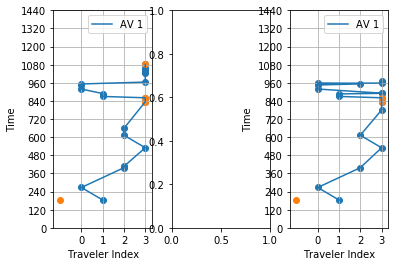

In [187]:
plt.pyplot.subplot(1,3,1)
pod. plot_route_info_schedule(route_info,sorted_trips,num_cav)
plt.pyplot.scatter(route_info.loc[(route_info.orig_node_index.isin(target_request)) ,'p_id'],
                    route_info.loc[(route_info.orig_node_index.isin(target_request)),'origin_arrival_time'])
plt.pyplot.yticks(np.arange(0,1441,120))
plt.pyplot.subplot(1,3,2)
# pod.plot_route_info_schedule(route_info4,sorted_trips,num_cav)
# plt.pyplot.scatter(route_info4.loc[(route_info4.orig_node_index.isin(target_request)) ,'p_id'],
#                     route_info4.loc[(route_info4.orig_node_index.isin(target_request)),'origin_arrival_time'])
plt.pyplot.subplot(1,3,3)
pod.plot_route_info_schedule(route_info3,sorted_trips,num_cav)
plt.pyplot.scatter(route_info3.loc[(route_info3.orig_node_index.isin(target_request)) ,'p_id'],
                    route_info3.loc[(route_info3.orig_node_index.isin(target_request)),'origin_arrival_time'])
plt.pyplot.yticks(np.arange(0,1441,120))

In [194]:
route_info3

,orig_zone,dest_zone,orig_node_index,dest_node_index,person_id,origin_arrival_time,dest_arrival_time,dest_expected_arrival_time,value_of_time,start_time,...,hh_id,hh_vehicle_id,shared_ride_flag,pickup_trip_flag,transit_utility,car_utility,car_time,orig_traveler,dest_traveler,p_id
0,6,6,1,32,9169665,23.0,23.8,23.8,0.1342,23.0,...,3132925.0,0.0,0,1,8.0,0.43236,0.8,9169665,9169665,0
2,6,1,2,33,9169665,160.0,163.4,163.4,0.1342,160.0,...,3132925.0,0.0,0,1,34.0,1.61103,3.4,9169665,9169665,0
4,1,6,3,34,9169665,177.0,180.5,180.5,0.1342,177.0,...,3132925.0,0.0,0,1,35.0,1.37945,3.5,9169665,9169665,0
6,6,9,4,35,9169665,200.0,203.2,203.2,0.1342,200.0,...,3132925.0,0.0,0,1,32.0,1.45919,3.2,9169665,9169665,0
8,9,6,7,5,9169665,216.2,220.0,220.0,0.1342,243.0,...,3132925.0,0.0,1,1,38.0,1.61471,3.8,9169665,9169668,0
9,6,6,5,38,9169668,220.0,221.5,246.8,0.1342,220.0,...,3132925.0,0.0,0,1,32.0,0.47262,1.1,9169668,9169665,3
10,6,9,38,36,9169668,221.5,224.8,223.2,0.1342,299.0,...,3132925.0,0.0,0,0,0.0,1.06275,3.3,9169665,9169668,3
12,9,6,6,37,9169668,233.0,236.8,236.8,0.1342,233.0,...,3132925.0,0.0,0,1,38.0,1.61471,3.8,9169668,9169668,3
14,6,1,8,39,9169668,299.0,303.3,303.3,0.1342,299.0,...,3132925.0,0.0,0,1,43.0,1.89181,4.3,9169668,9169668,3
15,1,6,39,9,0,303.3,308.0,308.0,0.0100,308.0,...,3132925.0,0.0,0,0,0.0,0.94375,3.4,9169668,9169666,-1


In [203]:
x4[53,24,0,4].ub

0.0

In [193]:
route_info3.loc[(route_info3.orig_node_index.isin(target_request)) ]

,orig_zone,dest_zone,orig_node_index,dest_node_index,person_id,origin_arrival_time,dest_arrival_time,dest_expected_arrival_time,value_of_time,start_time,...,hh_id,hh_vehicle_id,shared_ride_flag,pickup_trip_flag,transit_utility,car_utility,car_time,orig_traveler,dest_traveler,p_id
35,6,1,19,49,9169667,607.9,612.4,612.4,0.1342,619.0,...,3132925.0,0.0,0,1,45.0,1.75865,4.5,9169667,9169668,2
42,6,5,23,54,9169665,867.2,869.7,852.5,0.1342,850.0,...,3132925.0,0.0,0,1,25.0,1.12025,2.5,9169665,9169665,0


In [ ]:
sorted_trips.iloc[23]

In [ ]:
for i,j in zip(route_info.orig_node_index,route_info4.orig_node_index):
    print(i,j)

In [ ]:
for i in range(2*hh_num_trips+2):
    for j in range(2*hh_num_trips+2):
        for ti in range(num_time_interval):
            if (x4[i,j,0,ti].x==1):
                print(i,j,ti,C1[i,j],C[i,j,ti],C1[i,j]==C[i,j,ti])

In [ ]:
num_time_interval=5
if num_time_interval==5:
    TL=[0,280,420,780,960]
    TU=[280,420,780,960,1440]
else:
    TL=[i*1440/num_time_interval for i in range(num_time_interval)]
    TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,\
early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone\
    =prd.extract_hh_information(sorted_trips,Vehicular_Skim_Dict,\
                                Transit_AB_Cost_Skim_Dict,superzone_map,drivingcost_per_mile,num_time_interval)

In [ ]:
x_sol=np.zeros([2*hh_num_trips+2,2*hh_num_trips+2,num_cav])
T_sol=np.zeros([2*hh_num_trips+2])
for i in range(2*hh_num_trips+2):
    for j in range(2*hh_num_trips+2):
        for ve in range(num_cav):
            x_sol[i,j,ve]=x[i,j,ve].x
    T_sol[i]=T[i].x

In [ ]:
x_sol1,T_sol2=sod.extract_solution_from_route_info(route_info,hh_num_trips,num_cav)

In [ ]:
sod.move_neighborhood(x_sol,T_sol,sorted_trips,route_info,C,TT,TL,TU,num_time_interval,num_cav,hh_num_trips,
    expected_arrival_time,Vehicular_Skim_Dict,visit_candidate_zone,early_penalty,late_penalty,
    early_penalty_threshold,late_penalty_threshold,superzone_map)

In [ ]:
m3,T,objval=sod.optimal_start_time(sorted_trips,x_sol,T_sol,C,TT,TL,TU,num_time_interval,num_cav,hh_num_trips,expected_arrival_time,Vehicular_Skim_Dict,
    visit_candidate_zone,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,superzone_map)

In [ ]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=0
run_mode=2
darp_solutions=[]
cav_use_mode=0
num_time_interval=2
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1
time_window_flag=0

In [ ]:
target_hh=car_trips_shopping_special[(car_trips_shopping_special['hh_id']==target_hh_id)]\
.drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose',
                         'starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
darp_solutions={}
run_mode=2
num_time_interval=5
if num_time_interval==5:
    TL=[0,280,420,780,960]
    TU=[280,420,780,960,1440]
else:
    TL=[i*1440/num_time_interval for i in range(num_time_interval)]
    TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
darp_solutions_schedule_adjustement={}
darp_solutions_schedule_adjustement[target_hh_id]=sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim_Dict,Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                                    superzone_map,min_length,max_length,reward_mode,drivingcost_per_mile,share_ride_factor,output_flag,run_mode,num_cav,
                                    cav_use_mode,time_window_flag,single_model_runtime,num_time_interval,TL,TU,transit_zone_dict,transit_zone_candidates,
                                    TransitMazTazFlag,TransitSkimTimeIntervalLength)